### RNAPuzzle test

In [1]:
import os
import pandas as pd
import numpy as np
os.chdir("/home/adamczykb/rnaquanet/src")
architecture='ARES'
# os.mkdir(f'/home/adamczykb/rnaquanet/notebooks/puzzle38_compare_{architecture}')

In [2]:
res = pd.read_csv("../notebooks/ares_output.csv")

In [3]:
res['error']=res['pred']
res['name']=res['id'].str.split('.').str[0]

In [4]:
from pymol import cmd
result = pd.DataFrame(res,columns=["length","error","name"])
original = pd.read_csv('/home/adamczykb/rnaquanet/notebooks/PZ38r.csv')
original['Name']='PZ38_'+original['Lab']+'_'+original['Num'].astype(str)
result=pd.merge(result,original,left_on='name',right_on='Name')
result['diff']=result['error']-result['RMSD']


name = []
rmsd_C5prim = []
rmsd_global = []

for i in list(result['Name']):
    cmd.reinitialize()
    cmd.load(f"/home/adamczykb/rnaquanet/data/01_raw/PZ38/test/{i}.pdb")
    cmd.load(f"/home/adamczykb/rnaquanet/data/01_raw/PZ38/test/PZ38_solution_0.pdb")
    cmd.hide("everything")
    cmd.show("cartoon")
    cmd.color("white")
    rmsd_global.append(cmd.align(f"{i}","PZ38_solution_0",cycles=0)[0])
    rmsd_C5prim.append(cmd.align(f"/{i}////C5'","/PZ38_solution_0////C5'",cycles=0)[0])
    name.append(i)
result=pd.merge(result,pd.DataFrame(zip(name,rmsd_global,rmsd_C5prim),columns=['Name','true_rmsd_global','true_rmsd_C5prim']),on='Name')
result['true_rmsd_global_diff']=result['error']-result['true_rmsd_global']
result['true_rmsd_C5prim_diff']=result['error']-result['true_rmsd_C5prim']
result=result.sort_values('diff').reset_index(drop=True)
    

In [5]:
result[['Name','error','RMSD','diff','true_rmsd_global','true_rmsd_C5prim','true_rmsd_global_diff','true_rmsd_C5prim_diff']]

,Name,error,RMSD,diff,true_rmsd_global,true_rmsd_C5prim,true_rmsd_global_diff,true_rmsd_C5prim_diff
0,PZ38_Dfold_2,8.079540,21.296,-13.216460,21.296391,21.834007,-13.216850,-13.754467
1,PZ38_Dfold_5,8.079540,21.296,-13.216460,21.296391,21.834007,-13.216850,-13.754467
2,PZ38_Ding_5,10.069254,23.044,-12.974746,23.044178,23.236259,-12.974924,-13.167006
3,PZ38_Dfold_1,8.037863,20.279,-12.241137,20.278793,21.564806,-12.240931,-13.526943
4,PZ38_Dfold_3,7.601922,19.824,-12.222078,19.823502,21.004736,-12.221580,-13.402814
...,...,...,...,...,...,...,...,...
69,PZ38_Chen_3,8.311023,7.978,0.333023,7.977967,7.788988,0.333056,0.522035
70,PZ38_YangServer_5,9.336548,8.732,0.604548,8.731854,8.400113,0.604693,0.936435
71,PZ38_YangServer_2,10.127895,9.231,0.896895,9.230794,9.400671,0.897101,0.727224
72,PZ38_YangServer_4,13.457354,12.453,1.004354,12.452803,12.779362,1.004551,0.677992


In [6]:
display(f"MAE: {abs(result['diff']).mean()}")
display(f"MSE: {(result['diff']**2).mean()}")
display(f"MEDIAN: {abs(result['diff']).median()}")

'MAE: 4.637717475675676'

'MSE: 33.00630473333878'

'MEDIAN: 4.7720801999999996'

In [7]:
display(f"MAE: {abs(result['true_rmsd_global_diff']).mean()}")
display(f"MSE: {(result['true_rmsd_global_diff']**2).mean()}")
display(f"MEDIAN: {abs(result['true_rmsd_global_diff']).median()}")

'MAE: 4.637707530966104'

'MSE: 33.00648106881734'

'MEDIAN: 4.771595508380127'

In [8]:
display(f"MAE: {abs(result['true_rmsd_C5prim_diff']).mean()}")
display(f"MSE: {(result['true_rmsd_C5prim_diff']**2).mean()}")
display(f"MEDIAN: {abs(result['true_rmsd_C5prim_diff']).median()}")

'MAE: 5.519910231757747'

'MSE: 43.415411088160525'

'MEDIAN: 5.674509952697754'

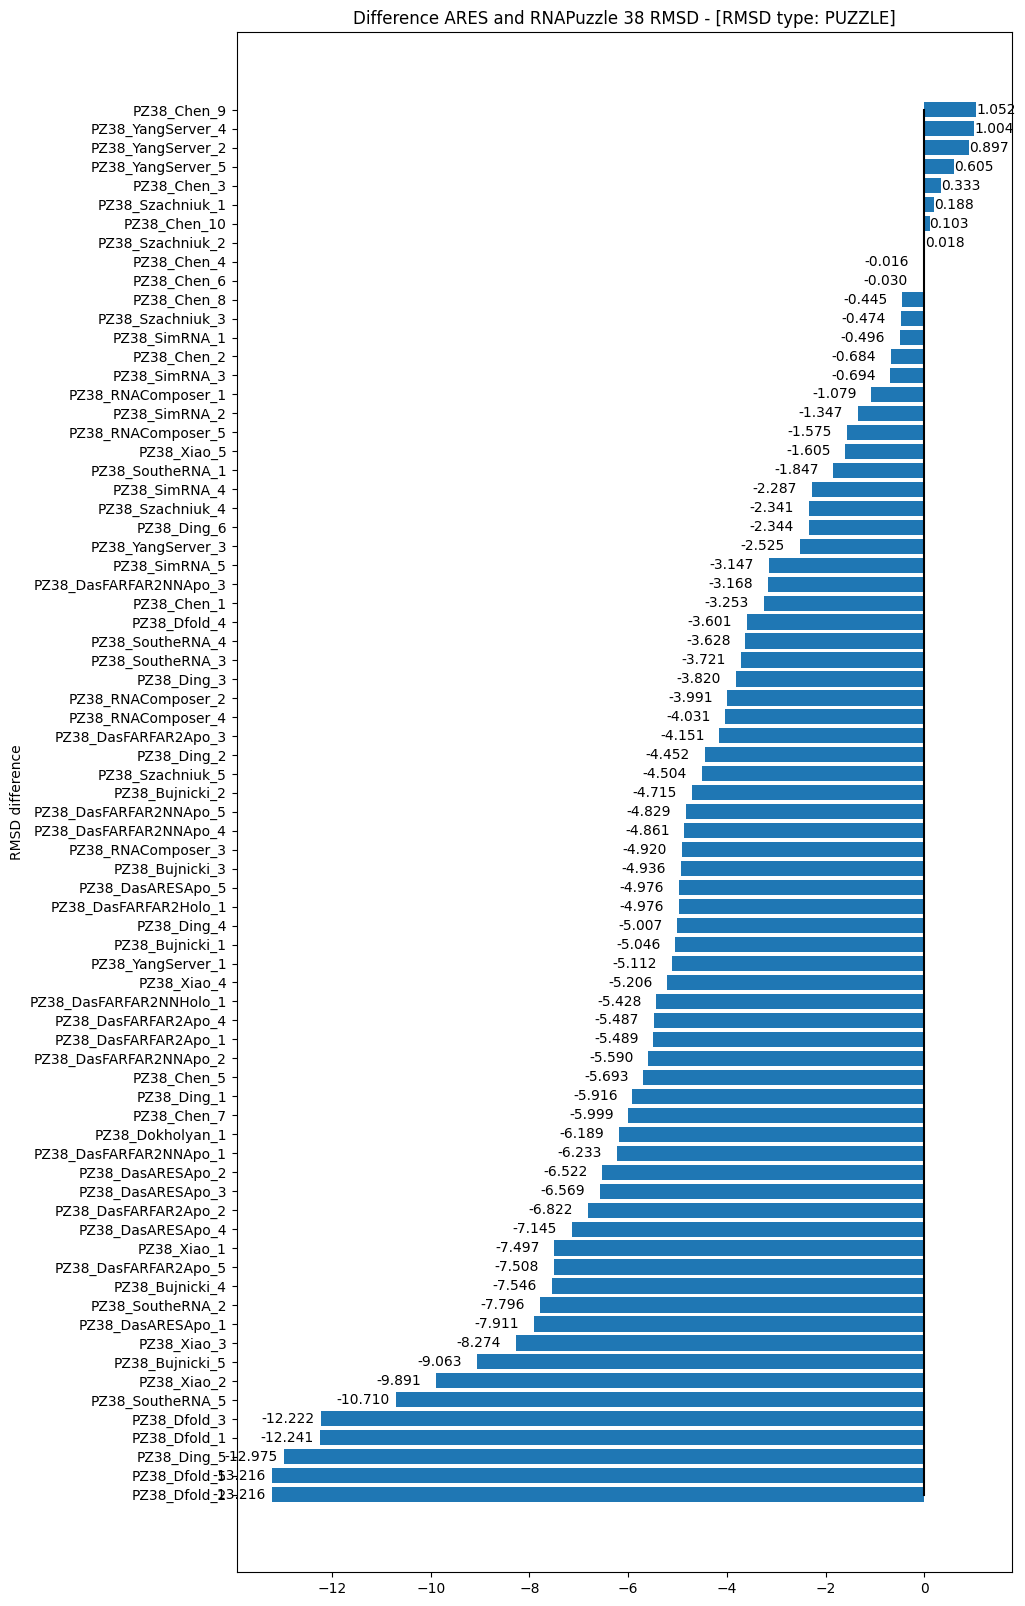

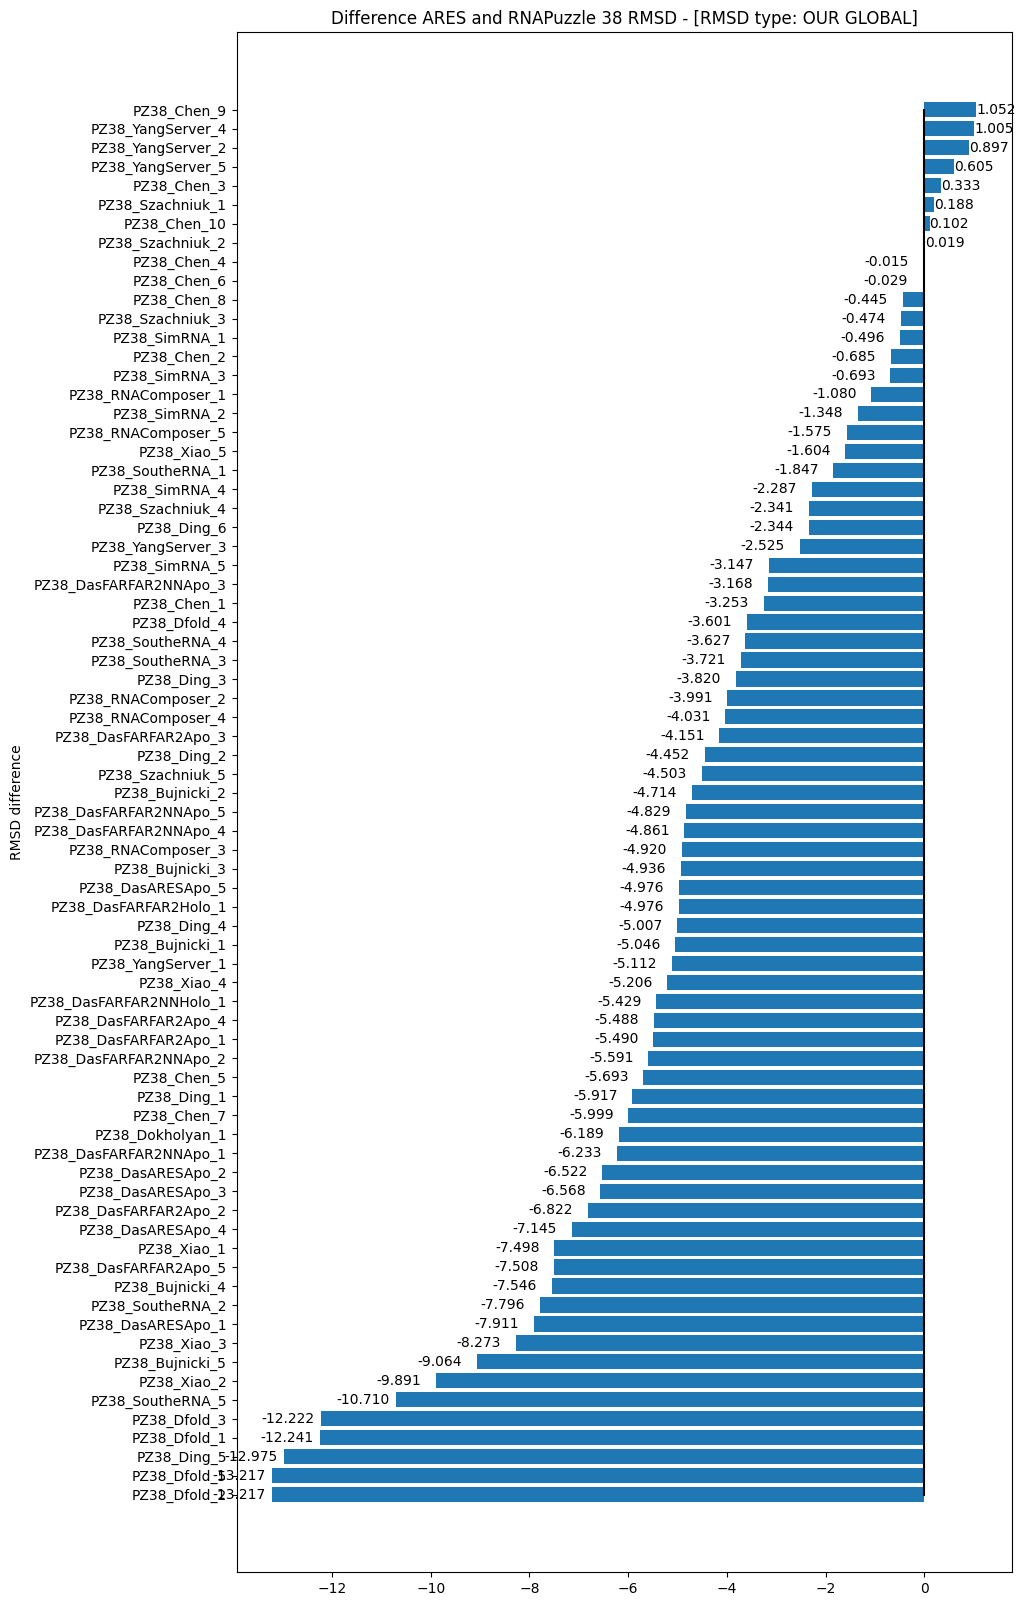

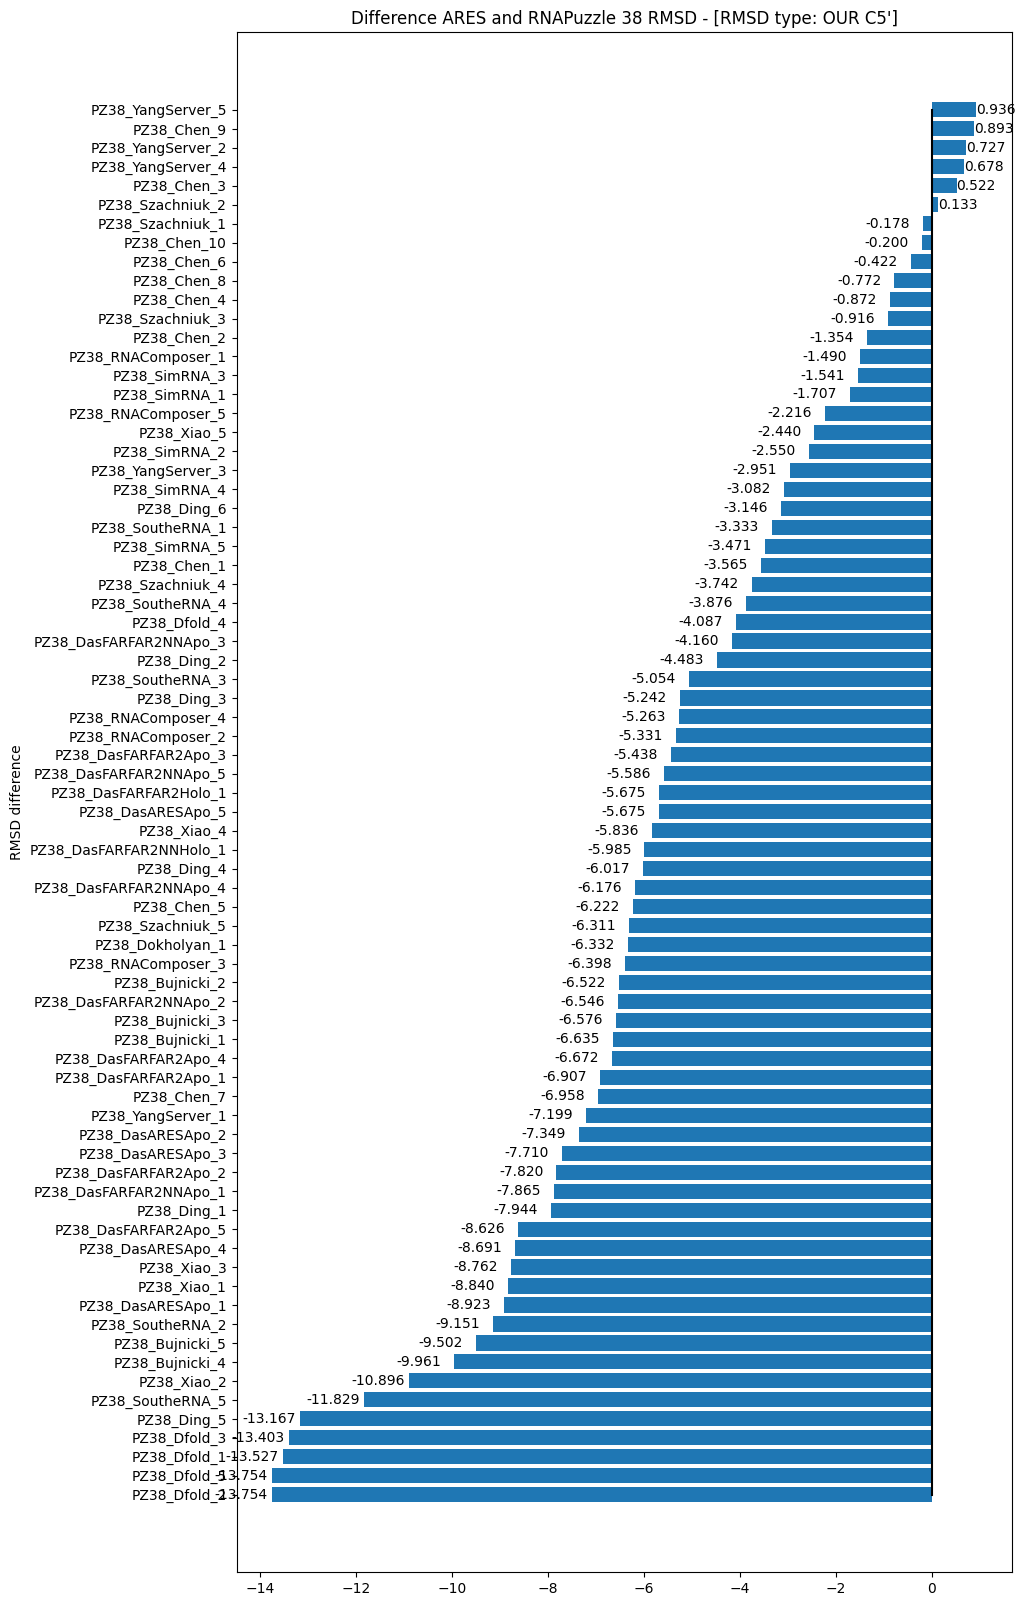

In [9]:
import matplotlib.pyplot as plt
# trained_on = dataset
for by in ['diff','true_rmsd_global_diff','true_rmsd_C5prim_diff']:
# Sample data
    match by:
        case 'diff':
            by_name='PUZZLE'
        case 'true_rmsd_global_diff':
            by_name='OUR GLOBAL'
        case 'true_rmsd_C5prim_diff':
            by_name='OUR C5\''
    
    result=result.sort_values(by=by).reset_index(drop=True)
    # Create a bar plot
    fig, ax = plt.subplots(figsize=(10, 20))

    # Plot bars
    bars = ax.barh(result['Name'], result[by], capsize=5)

    # Rotate the y-axis data series by 90 degrees

    # Set labels
    # plt.xticks(rotation=90)
    ax.set_ylabel('RMSD difference')
    ax.plot( [0]*len(result['Name']),result['Name'], linestyle='solid', linewidth=1.5, color='black')
    ax.set_title(f'Difference {architecture} and RNAPuzzle 38 RMSD - [RMSD type: {by_name}]')
    for i in range(len(result['Name'])):
        if result[by][i]<0:
            ax.text(result[by][i]-1.2,i,'{p:.3f}'.format(p=result[by][i]), verticalalignment='center')
        else:
            ax.text(result[by][i],i,'{p:.3f}'.format(p=result[by][i]), verticalalignment='center')
    # Show plot
    plt.savefig(f'/home/adamczykb/rnaquanet/notebooks/puzzle38_compare_{architecture}/{by}.svg')
    plt.show()

In [10]:
import scipy.stats as stats

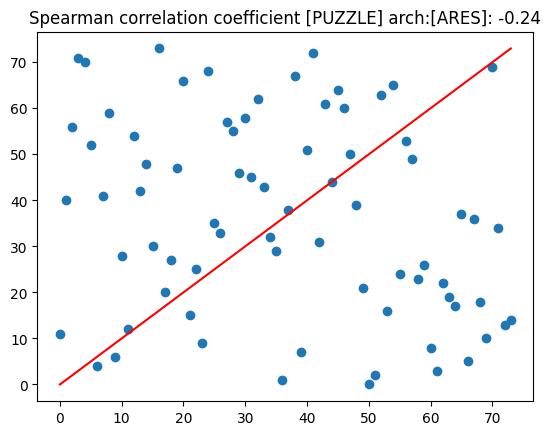

In [11]:
rmsd_sorted = result.sort_values(by='RMSD').index
error_sorted = result.sort_values(by='error').index
result['spearman_distance_puzzle']=abs(rmsd_sorted-error_sorted)

plt.scatter(rmsd_sorted, error_sorted)
plt.plot(np.sort(rmsd_sorted), np.sort(error_sorted), color='red')
plt.title("Spearman correlation coefficient [PUZZLE] arch:[{:s}]: {:.2f}".format(architecture,stats.spearmanr(rmsd_sorted,error_sorted).statistic))
plt.savefig(f'/home/adamczykb/rnaquanet/notebooks/puzzle38_compare_{architecture}/_PUZZLE_spearman.svg')

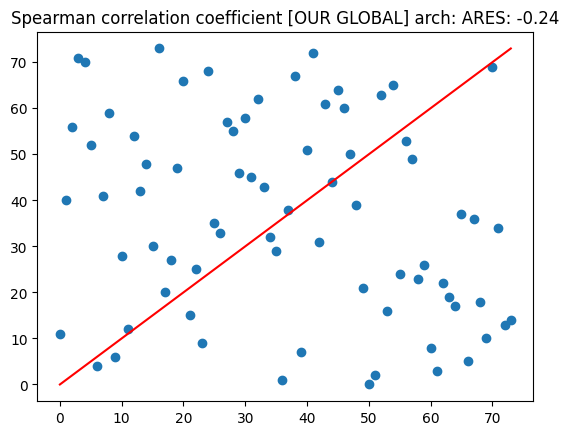

In [12]:
rmsd_sorted = result.sort_values(by='true_rmsd_global').index
error_sorted = result.sort_values(by='error').index
result['spearman_distance_global']=abs(rmsd_sorted-error_sorted)
plt.scatter(rmsd_sorted, error_sorted)
plt.plot(np.sort(rmsd_sorted), np.sort(error_sorted), color='red')
plt.title("Spearman correlation coefficient [OUR GLOBAL] arch: {:s}: {:.2f}".format(architecture,stats.spearmanr(rmsd_sorted,error_sorted).statistic))
plt.savefig(f'/home/adamczykb/rnaquanet/notebooks/puzzle38_compare_{architecture}/_GLOBAL_spearman.svg')

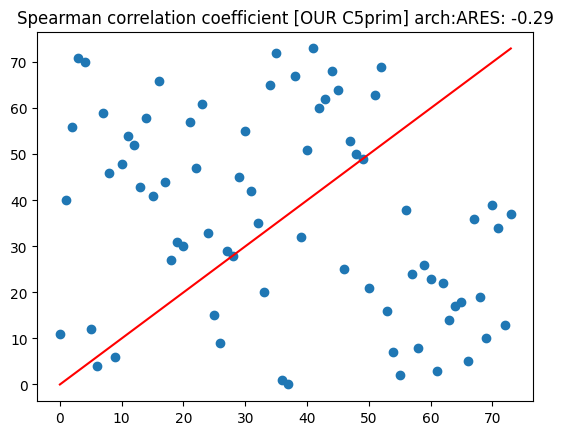

In [13]:
rmsd_sorted = result.sort_values(by='true_rmsd_C5prim').index
error_sorted = result.sort_values(by='error').index
result['spearman_distance_C5prim']=abs(rmsd_sorted-error_sorted)
plt.scatter(rmsd_sorted, error_sorted)
plt.plot(np.sort(rmsd_sorted), np.sort(error_sorted), color='red')
plt.title("Spearman correlation coefficient [OUR C5prim] arch:{:s}: {:.2f}".format(architecture,stats.spearmanr(rmsd_sorted,error_sorted).statistic))
plt.savefig(f'/home/adamczykb/rnaquanet/notebooks/puzzle38_compare_{architecture}/_C5prim_spearman.svg')

In [31]:
result[['Name','error','RMSD','diff','true_rmsd_global','true_rmsd_C5prim','true_rmsd_global_diff','true_rmsd_C5prim_diff','spearman_distance_puzzle','spearman_distance_global','spearman_distance_C5prim']].to_csv(f'/home/adamczykb/rnaquanet/notebooks/puzzle38_compare_{architecture}/PZ38r_.csv',index=False)

In [32]:
result[['Name','error','RMSD','diff','true_rmsd_global','true_rmsd_C5prim','true_rmsd_global_diff','true_rmsd_C5prim_diff','spearman_distance_puzzle','spearman_distance_global','spearman_distance_C5prim']]

,Name,error,RMSD,diff,true_rmsd_global,true_rmsd_C5prim,true_rmsd_global_diff,true_rmsd_C5prim_diff,spearman_distance_puzzle,spearman_distance_global,spearman_distance_C5prim
0,PZ38_Dfold_2,8.079540,21.296,-13.216460,21.027428,21.834007,-12.947887,-13.754467,58,50,64
1,PZ38_Dfold_5,8.079540,21.296,-13.216460,21.027428,21.834007,-12.947887,-13.754467,40,45,48
2,PZ38_Dfold_3,7.601922,19.824,-12.222078,19.823502,21.004736,-12.221580,-13.402814,59,62,53
3,PZ38_SoutheRNA_5,7.270250,17.980,-10.709750,17.114695,19.099081,-9.844444,-11.828831,13,15,22
4,PZ38_Xiao_2,9.856991,19.748,-9.891009,19.748251,20.753014,-9.891260,-10.896023,16,24,24
...,...,...,...,...,...,...,...,...,...,...,...
69,PZ38_YangServer_2,10.127895,9.231,0.896895,9.001807,9.400671,1.126088,0.727224,67,66,59
70,PZ38_Chen_9,9.291395,8.239,1.052395,7.742313,8.398361,1.549082,0.893034,49,50,50
71,PZ38_YangServer_5,9.336548,8.732,0.604548,7.586492,8.400113,1.750056,0.936435,9,8,8
72,PZ38_Ding_5,10.069254,23.044,-12.974746,9.852570,9.108221,0.216684,0.961033,35,34,34
